<a href="https://colab.research.google.com/github/seven320/Spacecat/blob/main/StyleGAN2_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 21 12:19:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from typing import Tuple, List
from tqdm import tqdm

from PIL import Image

## train style GAN2 model for this cat doesn't exists

* prepare kaggle account and kaggle.json in your google drive

In [3]:
import os, sys
import shutil

COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
!cp drive/MyDrive/kaggle/kaggle.json /root/.kaggle/kaggle.json

In [5]:
!git clone https://github.com/seven320/stylegan2-pytorch.git
!pip install kaggle > /dev/null
!pip install Ninja

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 403 (delta 3), reused 7 (delta 2), pack-reused 392
Receiving objects: 100% (403/403), 122.52 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (203/203), done.
     |████████████████████████████████| 108 kB 4.3 MB/s 


# Prepare Dataset

In [6]:
!kaggle datasets download -d crawford/cat-dataset

100% 4.04G/4.04G [01:38<00:00, 84.9MB/s]
100% 4.04G/4.04G [01:38<00:00, 44.2MB/s]


In [7]:
shutil.unpack_archive("cat-dataset.zip")

In [8]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra

import enum
import numpy as np
import cv2 
from matplotlib import pyplot as plt
from keras.layers import *
import os

In [9]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    labels = load_labels(path)[1:]

    w,h = img.shape[:2]
    
    return img, labels , w , h

def load_labels(path):
    path = path + ".cat"
    
    with open(path,'r') as f:
        coordinates = f.readline()
        coordinates = str(coordinates).split(' ')[:-1]
    
    return list(map(int,coordinates))

CAT_00 00000441_010.jpg


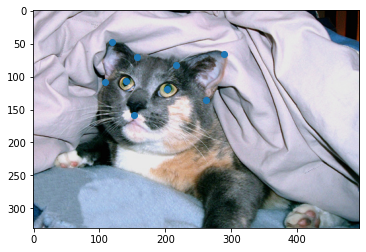

CAT_00 00000047_020.jpg


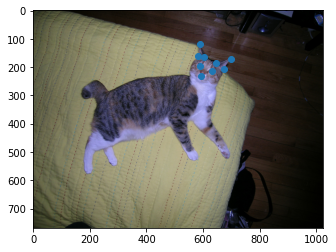

CAT_00 00000049_005.jpg


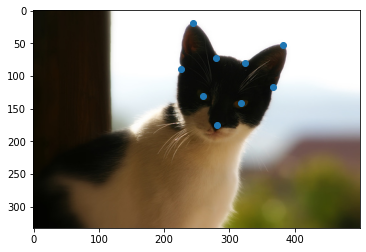

CAT_00 00000002_001.jpg


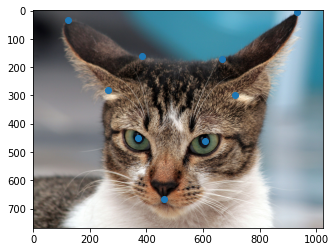

In [10]:
roots = [f"CAT_0{i}" for i in range(7)]
root = roots[0]
files = [i for i in os.listdir(root) if i.endswith(".jpg")]
for i, file in enumerate(files):
    print(root, file)
    x,y,w,h = load_image(os.path.join(root,file))
    plt.imshow(x)
    plt.scatter(y[0:18:2], y[1:18:2])
    plt.show()
    if i == 3:
        break

In [11]:
def cut_cats_center(image:np.ndarray, y:List[int], h:int, w:int) -> np.ndarray:
    """
    cut cat's image into a square with the cat's face in the center
    """
    x_min = min(y[0:18:2])
    x_max = max(y[0:18:2])
    y_min = min(y[1:18:2])
    y_max = max(y[1:18:2])

    # calculate cat face position
    x_center =(x_min + x_max) /2
    y_center = (y_min + y_max) / 2

    half_w = min(x_center, w - x_center)
    half_h = min(y_center, h - y_center)
    half_edge = min(half_w, half_h)

    y_s = int(y_center - half_edge)
    y_e = int(y_center + half_edge)
    x_s = int(x_center - half_edge)
    x_e = int(x_center + half_edge)
    assert y_e-y_s == x_e-x_s
    return image[y_s:y_e, x_s:x_e]


In [12]:
if not os.path.exists("prepare_data/cats"):
    os.makedirs("prepare_data/cats")

roots = [f"CAT_0{i}" for i in range(7)]
total_index = 0
for root in tqdm(roots):
    files = [i for i in os.listdir(root) if i.endswith(".jpg")]
    for i, file in enumerate(files):
        if os.path.exists(f"data/cats/{total_index:04}.jpg"):
            total_index += 1
            continue
        image, label,w,h = load_image(os.path.join(root,file))
        c_image = cut_cats_center(image, label, w, h)
        try:
            Image.fromarray(c_image).save(f"prepare_data/cats/{total_index:04}.jpg")
            total_index += 1
        except:
            pass

100%|██████████| 7/7 [02:14<00:00, 19.20s/it]


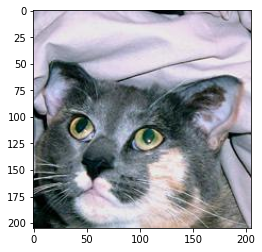

In [13]:
path = "prepare_data/cats/0000.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [14]:
!python stylegan2-pytorch/prepare_data.py --out prepare_data --size 256 --n_worker 4 /content/prepare_data

Make dataset of image sizes: 256
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: 

In [15]:
# !ls drive/MyDrive
try:
    os.makedirs("drive/MyDrive/cats/checkpoint")
except:
    print("file exists")
try:
    os.makedirs("drive/MyDrive/cats/sample")
except:
    print("file exists")

file exists
file exists


In [17]:
latest_ckpt = None
for i in range(10000, 10**6, 5000):
    if os.path.exists(f"drive/MyDrive/cats/checkpoint/{i:06}.pt"):
        latest_ckpt = f"drive/MyDrive/cats/checkpoint/{i:06}.pt"
    else:
        break

print(f"latest_ckpt: {latest_ckpt}")    

latest_ckpt: drive/MyDrive/cats/checkpoint/010000.pt


# Train StyleGAN2

In [ ]:
if latest_ckpt is None:
    !python stylegan2-pytorch/train.py  --iter 100000 --size 256 --batch 16 --n_sample 16 prepare_data --save_dir drive/MyDrive/cats 
else:
    !python stylegan2-pytorch/train.py  --iter 100000 --size 256 --batch 16 --n_sample 16 prepare_data --save_dir drive/MyDrive/cats --ckpt $latest_ckpt

load model: drive/MyDrive/cats/checkpoint/010000.pt
 10% 10000/100000 [00:00<?, ?it/s]/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu111. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
d: 1.0290; g: 0.8291; r1: 0.0120; path: 0.0823; mean path: 0.0027; augment: 0.0000:  10% 10000/100000 [00:06<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
d: 0.9150; g: 1.1875; r1: 0.0203; path: 0.0124; mean path: 0.3241; augment: 0.0000:  26% 25741/100000 [14:35:14<68:39:50,  3.33s/it]